<a href="https://colab.research.google.com/github/utsav-195/sentiment-analysis-using-rnn-in-pytorch/blob/main/Sentiment%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!tar -xvf "/content/drive/My Drive/D4NLP/Ass 1/rt-polaritydata.tar.gz" -C "/content/drive/My Drive/D4NLP/Ass 1/"

tar: option requires an argument -- 'f'
Try 'tar --help' or 'tar --usage' for more information.
rt-polaritydata.README.1.0.txt
rt-polaritydata/rt-polarity.neg
rt-polaritydata/rt-polarity.pos


In [1]:
!pip install pyprind

In [50]:
import numpy as np
import pandas as pd
import torch
from torchtext import data
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchtext
from torch.autograd import Variable
from tqdm import tqdm
import nltk

import random
from sklearn.metrics import classification_report

import pyprind
import matplotlib.pyplot as plt

%matplotlib inline  

#Pre-Processing

In [ ]:
data_pos = []
with open("/content/drive/My Drive/D4NLP/Ass 1/rt-polaritydata/rt-polarity.pos",encoding='latin-1') as f:
  for line in f:
    line  = line[:-2]
    line = line.replace("'t","t")
    line = line.replace("'"," '")
    line = line.replace("/"," / ")
    line = line.replace("-"," - ")
    line = line.replace("["," [ ")
    line = line.replace("]"," ] ")
    data_pos.append(line)

In [ ]:
# creating train, dev, test split positive reviews
data_pos_train = data_pos[:int(len(data_pos)*0.6)]
data_pos_dev = data_pos[int(len(data_pos)*0.6):int(len(data_pos)*0.8)]
data_pos_test = data_pos[int(len(data_pos)*0.8):]

data_pos_train = np.asarray(data_pos_train)
data_pos_dev = np.asarray(data_pos_dev)
data_pos_test = np.asarray(data_pos_test)

y_pos_train = np.asarray([1]*len(data_pos_train))
y_pos_dev = np.asarray([1]*len(data_pos_dev))
y_pos_test = np.asarray([1]*len(data_pos_test))

print(data_pos_train.shape)
print(data_pos_dev.shape)
print(data_pos_test.shape)

(3198,)
(1066,)
(1067,)


In [ ]:
# reading the negative reviews
data_neg = []
with open("/content/drive/My Drive/D4NLP/Ass 1/rt-polaritydata/rt-polarity.neg",encoding='latin-1') as f:
    for line in f:
        line  = line[:-2]
        line = line.replace("'t","t")
        line = line.replace("'"," '")
        line = line.replace("/"," / ")
        line = line.replace("-"," - ")
        line = line.replace("["," [ ")
        line = line.replace("]"," ] ")
        data_neg.append(line)

In [ ]:
# creating train, dev, test split for negative reviews
data_neg_train = data_neg[:int(len(data_neg)*0.6)]
data_neg_dev = data_neg[int(len(data_neg)*0.6):int(len(data_neg)*0.8)]
data_neg_test = data_neg[int(len(data_neg)*0.8):]

data_neg_train = np.asarray(data_neg_train)
data_neg_dev = np.asarray(data_neg_dev)
data_neg_test = np.asarray(data_neg_test)

y_neg_train = np.asarray([0]*len(data_neg_train))
y_neg_dev = np.asarray([0]*len(data_neg_dev))
y_neg_test = np.asarray([0]*len(data_neg_test))

print(data_neg_train.shape)
print(data_neg_dev.shape)
print(data_neg_test.shape)

(3198,)
(1066,)
(1067,)


In [ ]:
x_train = np.concatenate((data_pos_train, data_neg_train), axis=0)
x_dev = np.concatenate((data_pos_dev, data_neg_dev), axis=0)
x_test = np.concatenate((data_pos_test, data_neg_test), axis=0)

y_train = np.concatenate((y_pos_train, y_neg_train), axis=0)
y_dev = np.concatenate((y_pos_dev, y_neg_dev), axis=0)
y_test = np.concatenate((y_pos_test, y_neg_test), axis=0)

print(x_train.shape)
print(y_train.shape)


(6396,)
(6396,)


In [ ]:
def seq_length(data,label,seq_len):
  data_seq_len = []
  for i in range(len(data)):
    data_seq_len.append(" ".join(data[i].split()[:seq_len]))
  df = pd.DataFrame()
  df['reviews'] = data_seq_len
  df['senti'] = label

  df = df.sample(frac = 1).reset_index(drop=True)

  return df

In [ ]:
seq_len = 35
df_train = seq_length(x_train,y_train,seq_len)
df_dev = seq_length(x_dev,y_dev,seq_len)
df_test = seq_length(x_test,y_test,seq_len)

In [ ]:
!mkdir "/content/drive/My Drive/D4NLP/Ass 1/torchtext_data/"

In [ ]:
df_train.to_csv("/content/drive/My Drive/D4NLP/Ass 1/torchtext_data/train.csv", index=False)
df_test.to_csv("/content/drive/My Drive/D4NLP/Ass 1/torchtext_data/test.csv", index=False)
df_dev.to_csv("/content/drive/My Drive/D4NLP/Ass 1/torchtext_data/dev.csv", index=False)

# Referenced

https://www.kaggle.com/kuldeep7688/simple-rnn-using-glove-embeddings-in-pytorch

https://github.com/bentrevett/pytorch-sentiment-analysis

##Loading Data

In [3]:
# sample tokenizer which you can use
def tokenizer(text):
    return [tok for tok in text.split()]

In [4]:
# tokenizer = "spacy" uses spacy's tokenizer
TEXT = data.Field(sequential=True, tokenize=tokenizer)
LABEL = data.LabelField(dtype=torch.long, sequential=False)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# loading train, test and validation data 
train_data, dev_data, test_data = data.TabularDataset.splits(
    path="/content/drive/My Drive/D4NLP/Ass 1/torchtext_data/", train="train.csv", 
    validation="dev.csv", test="test.csv",format="csv", skip_header=True, 
    fields=[('reviews', TEXT), ('senti', LABEL)]
)

In [7]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of valid examples: {len(dev_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 6396
Number of valid examples: 2132
Number of testing examples: 2134


In [8]:
TEXT.build_vocab(train_data, vectors=torchtext.vocab.Vectors("/content/drive/My Drive/D4NLP/Ass 1/glove.6B.300d.txt"), 
                 max_size=40000, min_freq=1)
LABEL.build_vocab(train_data)

In [9]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 14410
Unique tokens in LABEL vocabulary: 2


In [10]:
BATCH_SIZE = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# keep in mind the sort_key option 
train_iterator, dev_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, dev_data, test_data), sort_key=lambda x: len(x.reviews),
    batch_size=BATCH_SIZE,
    device=device)

In [11]:
for i in train_iterator:
  print(i)
  break


[torchtext.data.batch.Batch of size 32]
	[.reviews]:[torch.cuda.LongTensor of size 35x32 (GPU 0)]
	[.senti]:[torch.cuda.LongTensor of size 32 (GPU 0)]


## RNN

In [12]:
class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):

        #x = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(x))
        
        #embedded = [sent len, batch size, emb dim]
        # print(x.shape)
        # print(embedded.shape)
        #pack sequence
        # packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)

        output, hidden = self.rnn(embedded)
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))

        hidden = self.dropout(hidden)
        
        out = self.fc(hidden)
        return out

In [13]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 300
OUTPUT_DIM = 2
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model_rnn = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            DROPOUT)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [16]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

model_rnn.embedding.weight.data = pretrained_embeddings.cuda()

class_weights = torch.tensor([1.0, 1.0]).cuda()

optimizer = optim.Adam(model_rnn.parameters(), lr=0.00003)

criterion = nn.CrossEntropyLoss(weight=class_weights)

model_rnn = model_rnn.to(device)
criterion = criterion.to(device)

torch.Size([14410, 300])


In [17]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    preds, ind= torch.max(F.softmax(preds, dim=-1), 1)
    correct = (ind == y).float()
    acc = correct.sum()/float(len(correct))

    return acc

In [18]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    bar = pyprind.ProgBar(len(iterator), bar_char='█')
    for batch in iterator:
        
        optimizer.zero_grad()
        # batch, batch_lengths = batch.reviews

        predictions = model(batch.reviews).squeeze(0)
#         print(predictions.shape, batch.Label.shape, model(batch.Text).shape)
        # print("idar")
        # print(predictions.shape)
        # print(batch.senti.reshape((len(batch.senti),1)).shape)

        loss = criterion(predictions, batch.senti)

        acc = binary_accuracy(predictions, batch.senti)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        bar.update()
    
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [19]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        bar = pyprind.ProgBar(len(iterator), bar_char='█')
        for batch in iterator:

            predictions = model(batch.reviews).squeeze(0)
            
            loss = criterion(predictions, batch.senti)
            
            acc = binary_accuracy(predictions, batch.senti)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            bar.update()
    
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [20]:
N_EPOCHS = 100
train_rnn_loss = []
train_rnn_acc = []
dev_rnn_loss = []
dev_rnn_acc = []


for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model_rnn, train_iterator, optimizer, criterion)
    dev_loss, dev_acc = evaluate(model_rnn, dev_iterator, criterion)
    
    train_rnn_loss.append(train_loss)
    train_rnn_acc.append(train_acc)

    dev_rnn_loss.append(dev_loss)
    dev_rnn_acc.append(dev_acc)


    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {dev_loss:.3f} | Val. Acc: {dev_acc*100:.2f}% |')

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 01 | Train Loss: 0.695 | Train Acc: 49.39% | Val. Loss: 0.697 | Val. Acc: 50.32% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 02 | Train Loss: 0.693 | Train Acc: 50.04% | Val. Loss: 0.695 | Val. Acc: 50.46% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 03 | Train Loss: 0.693 | Train Acc: 49.84% | Val. Loss: 0.693 | Val. Acc: 51.11% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 04 | Train Loss: 0.693 | Train Acc: 51.63% | Val. Loss: 0.692 | Val. Acc: 51.57% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 05 | Train Loss: 0.690 | Train Acc: 50.68% | Val. Loss: 0.691 | Val. Acc: 51.74% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 06 | Train Loss: 0.690 | Train Acc: 52.02% | Val. Loss: 0.688 | Val. Acc: 53.20% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 07 | Train Loss: 0.687 | Train Acc: 53.88% | Val. Loss: 0.676 | Val. Acc: 55.64% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 08 | Train Loss: 0.611 | Train Acc: 67.48% | Val. Loss: 0.578 | Val. Acc: 69.29% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 09 | Train Loss: 0.554 | Train Acc: 72.09% | Val. Loss: 0.567 | Val. Acc: 70.07% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 10 | Train Loss: 0.543 | Train Acc: 73.45% | Val. Loss: 0.545 | Val. Acc: 72.06% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 11 | Train Loss: 0.534 | Train Acc: 73.74% | Val. Loss: 0.533 | Val. Acc: 72.63% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 12 | Train Loss: 0.521 | Train Acc: 74.98% | Val. Loss: 0.532 | Val. Acc: 73.47% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 13 | Train Loss: 0.514 | Train Acc: 75.47% | Val. Loss: 0.532 | Val. Acc: 73.04% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 14 | Train Loss: 0.512 | Train Acc: 75.41% | Val. Loss: 0.541 | Val. Acc: 72.22% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 15 | Train Loss: 0.500 | Train Acc: 76.53% | Val. Loss: 0.521 | Val. Acc: 74.36% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 16 | Train Loss: 0.499 | Train Acc: 76.40% | Val. Loss: 0.518 | Val. Acc: 74.26% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 17 | Train Loss: 0.489 | Train Acc: 76.77% | Val. Loss: 0.525 | Val. Acc: 72.84% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 18 | Train Loss: 0.491 | Train Acc: 76.96% | Val. Loss: 0.518 | Val. Acc: 74.68% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 19 | Train Loss: 0.479 | Train Acc: 77.38% | Val. Loss: 0.525 | Val. Acc: 73.52% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 20 | Train Loss: 0.486 | Train Acc: 77.33% | Val. Loss: 0.520 | Val. Acc: 74.00% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 21 | Train Loss: 0.472 | Train Acc: 78.32% | Val. Loss: 0.526 | Val. Acc: 74.22% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 22 | Train Loss: 0.466 | Train Acc: 78.64% | Val. Loss: 0.528 | Val. Acc: 73.83% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 23 | Train Loss: 0.465 | Train Acc: 78.78% | Val. Loss: 0.511 | Val. Acc: 74.82% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 24 | Train Loss: 0.457 | Train Acc: 79.13% | Val. Loss: 0.508 | Val. Acc: 74.85% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 25 | Train Loss: 0.457 | Train Acc: 79.30% | Val. Loss: 0.505 | Val. Acc: 75.29% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 26 | Train Loss: 0.453 | Train Acc: 79.48% | Val. Loss: 0.509 | Val. Acc: 74.71% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 27 | Train Loss: 0.445 | Train Acc: 79.56% | Val. Loss: 0.512 | Val. Acc: 74.82% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 28 | Train Loss: 0.448 | Train Acc: 79.97% | Val. Loss: 0.508 | Val. Acc: 75.21% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 29 | Train Loss: 0.440 | Train Acc: 80.02% | Val. Loss: 0.508 | Val. Acc: 75.15% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 30 | Train Loss: 0.430 | Train Acc: 81.20% | Val. Loss: 0.509 | Val. Acc: 74.85% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 31 | Train Loss: 0.432 | Train Acc: 81.26% | Val. Loss: 0.517 | Val. Acc: 74.54% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 32 | Train Loss: 0.432 | Train Acc: 80.40% | Val. Loss: 0.504 | Val. Acc: 75.13% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 33 | Train Loss: 0.425 | Train Acc: 80.83% | Val. Loss: 0.520 | Val. Acc: 74.68% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 34 | Train Loss: 0.423 | Train Acc: 80.65% | Val. Loss: 0.508 | Val. Acc: 75.20% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 35 | Train Loss: 0.417 | Train Acc: 81.16% | Val. Loss: 0.513 | Val. Acc: 74.73% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 36 | Train Loss: 0.413 | Train Acc: 81.33% | Val. Loss: 0.502 | Val. Acc: 75.27% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 37 | Train Loss: 0.410 | Train Acc: 82.30% | Val. Loss: 0.505 | Val. Acc: 74.62% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 38 | Train Loss: 0.394 | Train Acc: 83.20% | Val. Loss: 0.504 | Val. Acc: 75.57% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 39 | Train Loss: 0.413 | Train Acc: 81.58% | Val. Loss: 0.508 | Val. Acc: 74.82% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 40 | Train Loss: 0.400 | Train Acc: 82.74% | Val. Loss: 0.507 | Val. Acc: 74.92% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 41 | Train Loss: 0.391 | Train Acc: 83.43% | Val. Loss: 0.510 | Val. Acc: 74.14% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 42 | Train Loss: 0.392 | Train Acc: 82.79% | Val. Loss: 0.510 | Val. Acc: 74.14% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 43 | Train Loss: 0.381 | Train Acc: 83.78% | Val. Loss: 0.511 | Val. Acc: 74.85% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 44 | Train Loss: 0.383 | Train Acc: 83.60% | Val. Loss: 0.519 | Val. Acc: 74.21% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 45 | Train Loss: 0.366 | Train Acc: 84.17% | Val. Loss: 0.512 | Val. Acc: 74.40% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 46 | Train Loss: 0.371 | Train Acc: 84.23% | Val. Loss: 0.522 | Val. Acc: 74.08% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 47 | Train Loss: 0.374 | Train Acc: 83.66% | Val. Loss: 0.529 | Val. Acc: 74.31% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 48 | Train Loss: 0.371 | Train Acc: 83.86% | Val. Loss: 0.525 | Val. Acc: 73.94% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 49 | Train Loss: 0.372 | Train Acc: 83.73% | Val. Loss: 0.527 | Val. Acc: 73.98% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 50 | Train Loss: 0.368 | Train Acc: 84.49% | Val. Loss: 0.537 | Val. Acc: 73.58% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 51 | Train Loss: 0.353 | Train Acc: 85.17% | Val. Loss: 0.526 | Val. Acc: 74.26% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 52 | Train Loss: 0.348 | Train Acc: 85.47% | Val. Loss: 0.525 | Val. Acc: 74.36% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 53 | Train Loss: 0.352 | Train Acc: 85.32% | Val. Loss: 0.531 | Val. Acc: 73.82% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 54 | Train Loss: 0.350 | Train Acc: 85.54% | Val. Loss: 0.536 | Val. Acc: 73.98% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 55 | Train Loss: 0.349 | Train Acc: 85.29% | Val. Loss: 0.537 | Val. Acc: 73.96% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 56 | Train Loss: 0.335 | Train Acc: 86.38% | Val. Loss: 0.548 | Val. Acc: 74.31% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 57 | Train Loss: 0.336 | Train Acc: 86.04% | Val. Loss: 0.551 | Val. Acc: 74.31% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 58 | Train Loss: 0.325 | Train Acc: 86.25% | Val. Loss: 0.546 | Val. Acc: 74.10% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 59 | Train Loss: 0.329 | Train Acc: 86.43% | Val. Loss: 0.545 | Val. Acc: 73.98% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 60 | Train Loss: 0.335 | Train Acc: 85.71% | Val. Loss: 0.544 | Val. Acc: 74.08% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 61 | Train Loss: 0.317 | Train Acc: 86.93% | Val. Loss: 0.561 | Val. Acc: 73.33% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 62 | Train Loss: 0.315 | Train Acc: 87.05% | Val. Loss: 0.547 | Val. Acc: 74.48% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 63 | Train Loss: 0.311 | Train Acc: 87.46% | Val. Loss: 0.555 | Val. Acc: 74.82% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 64 | Train Loss: 0.317 | Train Acc: 87.23% | Val. Loss: 0.561 | Val. Acc: 73.82% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 65 | Train Loss: 0.313 | Train Acc: 87.59% | Val. Loss: 0.557 | Val. Acc: 74.15% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 66 | Train Loss: 0.300 | Train Acc: 88.04% | Val. Loss: 0.565 | Val. Acc: 74.22% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 67 | Train Loss: 0.293 | Train Acc: 88.38% | Val. Loss: 0.566 | Val. Acc: 74.38% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 68 | Train Loss: 0.297 | Train Acc: 88.20% | Val. Loss: 0.567 | Val. Acc: 73.56% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 69 | Train Loss: 0.299 | Train Acc: 87.43% | Val. Loss: 0.572 | Val. Acc: 74.51% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 70 | Train Loss: 0.292 | Train Acc: 88.29% | Val. Loss: 0.586 | Val. Acc: 73.70% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 71 | Train Loss: 0.296 | Train Acc: 88.10% | Val. Loss: 0.579 | Val. Acc: 74.08% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 72 | Train Loss: 0.294 | Train Acc: 87.96% | Val. Loss: 0.572 | Val. Acc: 74.10% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 73 | Train Loss: 0.287 | Train Acc: 88.13% | Val. Loss: 0.606 | Val. Acc: 72.68% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 74 | Train Loss: 0.281 | Train Acc: 88.74% | Val. Loss: 0.585 | Val. Acc: 73.19% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 75 | Train Loss: 0.286 | Train Acc: 88.74% | Val. Loss: 0.589 | Val. Acc: 73.36% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 76 | Train Loss: 0.272 | Train Acc: 88.99% | Val. Loss: 0.598 | Val. Acc: 73.68% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 77 | Train Loss: 0.273 | Train Acc: 89.22% | Val. Loss: 0.589 | Val. Acc: 73.73% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 78 | Train Loss: 0.272 | Train Acc: 89.32% | Val. Loss: 0.605 | Val. Acc: 73.92% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 79 | Train Loss: 0.264 | Train Acc: 89.64% | Val. Loss: 0.602 | Val. Acc: 73.78% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 80 | Train Loss: 0.268 | Train Acc: 89.41% | Val. Loss: 0.599 | Val. Acc: 73.92% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 81 | Train Loss: 0.271 | Train Acc: 89.35% | Val. Loss: 0.609 | Val. Acc: 73.87% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 82 | Train Loss: 0.262 | Train Acc: 89.93% | Val. Loss: 0.620 | Val. Acc: 73.78% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 83 | Train Loss: 0.255 | Train Acc: 90.14% | Val. Loss: 0.634 | Val. Acc: 73.64% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 84 | Train Loss: 0.252 | Train Acc: 89.80% | Val. Loss: 0.630 | Val. Acc: 74.79% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 85 | Train Loss: 0.266 | Train Acc: 89.20% | Val. Loss: 0.622 | Val. Acc: 73.82% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 86 | Train Loss: 0.258 | Train Acc: 90.10% | Val. Loss: 0.615 | Val. Acc: 73.64% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 87 | Train Loss: 0.248 | Train Acc: 90.50% | Val. Loss: 0.626 | Val. Acc: 73.82% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 88 | Train Loss: 0.242 | Train Acc: 90.73% | Val. Loss: 0.625 | Val. Acc: 73.54% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 89 | Train Loss: 0.251 | Train Acc: 90.09% | Val. Loss: 0.622 | Val. Acc: 73.10% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 90 | Train Loss: 0.245 | Train Acc: 90.27% | Val. Loss: 0.641 | Val. Acc: 73.92% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 91 | Train Loss: 0.231 | Train Acc: 90.87% | Val. Loss: 0.633 | Val. Acc: 73.00% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 92 | Train Loss: 0.244 | Train Acc: 90.71% | Val. Loss: 0.628 | Val. Acc: 72.40% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 93 | Train Loss: 0.241 | Train Acc: 90.59% | Val. Loss: 0.633 | Val. Acc: 73.92% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 94 | Train Loss: 0.241 | Train Acc: 90.23% | Val. Loss: 0.645 | Val. Acc: 72.47% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 95 | Train Loss: 0.230 | Train Acc: 90.97% | Val. Loss: 0.657 | Val. Acc: 74.06% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 96 | Train Loss: 0.233 | Train Acc: 91.12% | Val. Loss: 0.646 | Val. Acc: 73.64% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 97 | Train Loss: 0.226 | Train Acc: 91.26% | Val. Loss: 0.647 | Val. Acc: 73.08% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 98 | Train Loss: 0.234 | Train Acc: 90.94% | Val. Loss: 0.662 | Val. Acc: 72.66% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 99 | Train Loss: 0.230 | Train Acc: 91.41% | Val. Loss: 0.661 | Val. Acc: 72.71% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 100 | Train Loss: 0.215 | Train Acc: 91.89% | Val. Loss: 0.663 | Val. Acc: 71.56% |



Total time elapsed: 00:00:00


## LSTM

In [21]:
class LSTM(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):

        #x = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(x))
        # print("here1")
        #embedded = [sent len, batch size, emb dim]
        # print(x.shape)
        # print(embedded.shape)
        output, (hidden,cell) = self.rnn(embedded)
        # print("here2")
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        # assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        # print(hidden)
        # print(hidden[0].shape)
        hidden = self.dropout(hidden)
        # print("here3")
        out = self.fc(hidden)
        # print("here4")
        return out

In [22]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 300
OUTPUT_DIM = 2
DROPOUT = 0.5

model_lstm = LSTM(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, DROPOUT)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [23]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

model_lstm.embedding.weight.data = pretrained_embeddings

class_weights = torch.tensor([1.0, 1.0])

optimizer = optim.Adam(model_lstm.parameters(), lr=0.00003)

criterion = nn.CrossEntropyLoss(weight=class_weights)

model_lstm = model_lstm.to(device)
criterion = criterion.to(device)

torch.Size([14410, 300])


In [24]:
N_EPOCHS = 100
train_lstm_loss = []
train_lstm_acc = []
dev_lstm_loss = []
dev_lstm_acc = []

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model_lstm, train_iterator, optimizer, criterion)
    dev_loss, dev_acc = evaluate(model_lstm, dev_iterator, criterion)
    
    train_lstm_loss.append(train_loss)
    train_lstm_acc.append(train_acc)

    dev_lstm_loss.append(dev_loss)
    dev_lstm_acc.append(dev_acc)

    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {dev_loss:.3f} | Val. Acc: {dev_acc*100:.2f}% |')

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 01 | Train Loss: 0.694 | Train Acc: 49.69% | Val. Loss: 0.693 | Val. Acc: 51.10% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 02 | Train Loss: 0.693 | Train Acc: 50.17% | Val. Loss: 0.692 | Val. Acc: 54.81% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 03 | Train Loss: 0.693 | Train Acc: 50.27% | Val. Loss: 0.691 | Val. Acc: 56.88% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 04 | Train Loss: 0.692 | Train Acc: 50.74% | Val. Loss: 0.690 | Val. Acc: 57.80% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 05 | Train Loss: 0.692 | Train Acc: 50.88% | Val. Loss: 0.688 | Val. Acc: 57.16% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 06 | Train Loss: 0.691 | Train Acc: 52.15% | Val. Loss: 0.686 | Val. Acc: 60.41% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 07 | Train Loss: 0.691 | Train Acc: 51.90% | Val. Loss: 0.683 | Val. Acc: 60.97% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 08 | Train Loss: 0.689 | Train Acc: 53.75% | Val. Loss: 0.675 | Val. Acc: 61.34% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 09 | Train Loss: 0.648 | Train Acc: 62.53% | Val. Loss: 0.611 | Val. Acc: 67.89% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 10 | Train Loss: 0.554 | Train Acc: 71.77% | Val. Loss: 0.564 | Val. Acc: 72.51% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 11 | Train Loss: 0.527 | Train Acc: 73.52% | Val. Loss: 0.562 | Val. Acc: 70.71% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 12 | Train Loss: 0.504 | Train Acc: 74.92% | Val. Loss: 0.542 | Val. Acc: 72.51% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 13 | Train Loss: 0.505 | Train Acc: 75.49% | Val. Loss: 0.532 | Val. Acc: 73.26% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 14 | Train Loss: 0.487 | Train Acc: 76.38% | Val. Loss: 0.525 | Val. Acc: 74.05% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 15 | Train Loss: 0.478 | Train Acc: 76.88% | Val. Loss: 0.521 | Val. Acc: 74.10% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 16 | Train Loss: 0.474 | Train Acc: 77.14% | Val. Loss: 0.532 | Val. Acc: 73.82% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 17 | Train Loss: 0.468 | Train Acc: 77.56% | Val. Loss: 0.515 | Val. Acc: 75.38% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 18 | Train Loss: 0.464 | Train Acc: 78.29% | Val. Loss: 0.516 | Val. Acc: 75.01% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 19 | Train Loss: 0.458 | Train Acc: 78.33% | Val. Loss: 0.516 | Val. Acc: 74.36% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 20 | Train Loss: 0.444 | Train Acc: 78.79% | Val. Loss: 0.505 | Val. Acc: 75.66% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 21 | Train Loss: 0.439 | Train Acc: 79.25% | Val. Loss: 0.501 | Val. Acc: 75.57% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 22 | Train Loss: 0.443 | Train Acc: 79.47% | Val. Loss: 0.502 | Val. Acc: 75.73% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 23 | Train Loss: 0.423 | Train Acc: 80.58% | Val. Loss: 0.497 | Val. Acc: 75.97% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 24 | Train Loss: 0.428 | Train Acc: 80.29% | Val. Loss: 0.508 | Val. Acc: 75.62% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 25 | Train Loss: 0.426 | Train Acc: 80.58% | Val. Loss: 0.493 | Val. Acc: 75.90% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 26 | Train Loss: 0.409 | Train Acc: 80.50% | Val. Loss: 0.492 | Val. Acc: 75.96% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 27 | Train Loss: 0.412 | Train Acc: 80.96% | Val. Loss: 0.490 | Val. Acc: 76.34% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 28 | Train Loss: 0.404 | Train Acc: 81.54% | Val. Loss: 0.485 | Val. Acc: 76.39% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 29 | Train Loss: 0.397 | Train Acc: 81.97% | Val. Loss: 0.491 | Val. Acc: 76.76% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 30 | Train Loss: 0.396 | Train Acc: 81.69% | Val. Loss: 0.488 | Val. Acc: 76.46% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 31 | Train Loss: 0.392 | Train Acc: 82.23% | Val. Loss: 0.487 | Val. Acc: 76.83% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 32 | Train Loss: 0.387 | Train Acc: 83.04% | Val. Loss: 0.485 | Val. Acc: 76.92% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 33 | Train Loss: 0.390 | Train Acc: 82.81% | Val. Loss: 0.481 | Val. Acc: 76.78% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 34 | Train Loss: 0.372 | Train Acc: 83.10% | Val. Loss: 0.493 | Val. Acc: 76.90% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 35 | Train Loss: 0.371 | Train Acc: 82.60% | Val. Loss: 0.497 | Val. Acc: 76.44% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 36 | Train Loss: 0.363 | Train Acc: 83.57% | Val. Loss: 0.473 | Val. Acc: 76.70% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 37 | Train Loss: 0.367 | Train Acc: 83.58% | Val. Loss: 0.482 | Val. Acc: 77.46% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 38 | Train Loss: 0.358 | Train Acc: 84.29% | Val. Loss: 0.473 | Val. Acc: 77.15% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 39 | Train Loss: 0.351 | Train Acc: 84.30% | Val. Loss: 0.483 | Val. Acc: 77.18% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 40 | Train Loss: 0.344 | Train Acc: 84.77% | Val. Loss: 0.481 | Val. Acc: 77.18% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 41 | Train Loss: 0.339 | Train Acc: 84.81% | Val. Loss: 0.479 | Val. Acc: 77.37% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 42 | Train Loss: 0.353 | Train Acc: 84.42% | Val. Loss: 0.486 | Val. Acc: 77.65% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 43 | Train Loss: 0.341 | Train Acc: 84.73% | Val. Loss: 0.488 | Val. Acc: 77.09% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 44 | Train Loss: 0.331 | Train Acc: 85.53% | Val. Loss: 0.477 | Val. Acc: 77.93% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 45 | Train Loss: 0.324 | Train Acc: 85.74% | Val. Loss: 0.495 | Val. Acc: 77.04% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 46 | Train Loss: 0.321 | Train Acc: 85.80% | Val. Loss: 0.484 | Val. Acc: 77.79% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 47 | Train Loss: 0.325 | Train Acc: 85.79% | Val. Loss: 0.495 | Val. Acc: 77.51% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 48 | Train Loss: 0.316 | Train Acc: 86.49% | Val. Loss: 0.479 | Val. Acc: 77.65% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 49 | Train Loss: 0.306 | Train Acc: 86.77% | Val. Loss: 0.470 | Val. Acc: 77.82% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 50 | Train Loss: 0.309 | Train Acc: 86.58% | Val. Loss: 0.486 | Val. Acc: 77.56% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 51 | Train Loss: 0.306 | Train Acc: 86.88% | Val. Loss: 0.486 | Val. Acc: 77.63% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 52 | Train Loss: 0.295 | Train Acc: 87.75% | Val. Loss: 0.507 | Val. Acc: 77.00% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 53 | Train Loss: 0.296 | Train Acc: 87.21% | Val. Loss: 0.481 | Val. Acc: 77.65% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 54 | Train Loss: 0.282 | Train Acc: 88.01% | Val. Loss: 0.500 | Val. Acc: 77.37% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 55 | Train Loss: 0.297 | Train Acc: 87.39% | Val. Loss: 0.489 | Val. Acc: 77.40% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 56 | Train Loss: 0.285 | Train Acc: 87.94% | Val. Loss: 0.484 | Val. Acc: 77.56% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 57 | Train Loss: 0.278 | Train Acc: 87.95% | Val. Loss: 0.489 | Val. Acc: 77.84% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 58 | Train Loss: 0.271 | Train Acc: 88.49% | Val. Loss: 0.484 | Val. Acc: 77.98% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 59 | Train Loss: 0.271 | Train Acc: 88.56% | Val. Loss: 0.485 | Val. Acc: 77.93% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 60 | Train Loss: 0.265 | Train Acc: 88.88% | Val. Loss: 0.499 | Val. Acc: 77.49% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 61 | Train Loss: 0.263 | Train Acc: 89.00% | Val. Loss: 0.493 | Val. Acc: 78.05% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 62 | Train Loss: 0.265 | Train Acc: 88.95% | Val. Loss: 0.510 | Val. Acc: 76.62% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 63 | Train Loss: 0.260 | Train Acc: 88.99% | Val. Loss: 0.491 | Val. Acc: 77.49% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 64 | Train Loss: 0.247 | Train Acc: 89.90% | Val. Loss: 0.517 | Val. Acc: 78.10% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 65 | Train Loss: 0.245 | Train Acc: 89.46% | Val. Loss: 0.498 | Val. Acc: 78.26% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 66 | Train Loss: 0.255 | Train Acc: 88.78% | Val. Loss: 0.521 | Val. Acc: 78.07% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 67 | Train Loss: 0.250 | Train Acc: 89.40% | Val. Loss: 0.509 | Val. Acc: 77.40% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 68 | Train Loss: 0.245 | Train Acc: 89.67% | Val. Loss: 0.509 | Val. Acc: 78.47% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 69 | Train Loss: 0.233 | Train Acc: 90.33% | Val. Loss: 0.519 | Val. Acc: 77.37% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 70 | Train Loss: 0.237 | Train Acc: 90.07% | Val. Loss: 0.506 | Val. Acc: 77.86% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 71 | Train Loss: 0.230 | Train Acc: 90.35% | Val. Loss: 0.538 | Val. Acc: 76.88% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 72 | Train Loss: 0.231 | Train Acc: 90.24% | Val. Loss: 0.553 | Val. Acc: 77.26% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 73 | Train Loss: 0.226 | Train Acc: 90.65% | Val. Loss: 0.508 | Val. Acc: 78.30% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 74 | Train Loss: 0.219 | Train Acc: 90.83% | Val. Loss: 0.590 | Val. Acc: 76.44% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 75 | Train Loss: 0.220 | Train Acc: 90.68% | Val. Loss: 0.514 | Val. Acc: 78.28% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 76 | Train Loss: 0.207 | Train Acc: 91.67% | Val. Loss: 0.528 | Val. Acc: 77.58% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 77 | Train Loss: 0.203 | Train Acc: 91.62% | Val. Loss: 0.536 | Val. Acc: 76.88% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 78 | Train Loss: 0.217 | Train Acc: 91.34% | Val. Loss: 0.509 | Val. Acc: 77.96% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 79 | Train Loss: 0.204 | Train Acc: 91.48% | Val. Loss: 0.574 | Val. Acc: 77.72% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 80 | Train Loss: 0.197 | Train Acc: 91.85% | Val. Loss: 0.540 | Val. Acc: 77.91% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 81 | Train Loss: 0.199 | Train Acc: 92.25% | Val. Loss: 0.533 | Val. Acc: 78.10% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 82 | Train Loss: 0.202 | Train Acc: 91.87% | Val. Loss: 0.494 | Val. Acc: 78.30% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 83 | Train Loss: 0.190 | Train Acc: 92.56% | Val. Loss: 0.522 | Val. Acc: 78.86% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 84 | Train Loss: 0.195 | Train Acc: 92.16% | Val. Loss: 0.512 | Val. Acc: 78.54% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 85 | Train Loss: 0.182 | Train Acc: 92.84% | Val. Loss: 0.547 | Val. Acc: 78.49% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 86 | Train Loss: 0.186 | Train Acc: 92.48% | Val. Loss: 0.543 | Val. Acc: 78.42% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 87 | Train Loss: 0.181 | Train Acc: 92.54% | Val. Loss: 0.539 | Val. Acc: 77.91% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 88 | Train Loss: 0.178 | Train Acc: 92.76% | Val. Loss: 0.563 | Val. Acc: 77.26% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 89 | Train Loss: 0.173 | Train Acc: 93.03% | Val. Loss: 0.522 | Val. Acc: 77.96% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 90 | Train Loss: 0.175 | Train Acc: 92.84% | Val. Loss: 0.561 | Val. Acc: 77.91% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 91 | Train Loss: 0.169 | Train Acc: 92.98% | Val. Loss: 0.565 | Val. Acc: 77.77% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 92 | Train Loss: 0.168 | Train Acc: 93.34% | Val. Loss: 0.561 | Val. Acc: 78.77% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 93 | Train Loss: 0.161 | Train Acc: 93.72% | Val. Loss: 0.583 | Val. Acc: 76.84% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 94 | Train Loss: 0.159 | Train Acc: 93.64% | Val. Loss: 0.570 | Val. Acc: 78.10% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 95 | Train Loss: 0.160 | Train Acc: 93.80% | Val. Loss: 0.599 | Val. Acc: 77.63% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 96 | Train Loss: 0.154 | Train Acc: 93.82% | Val. Loss: 0.604 | Val. Acc: 78.28% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 97 | Train Loss: 0.159 | Train Acc: 93.71% | Val. Loss: 0.563 | Val. Acc: 77.86% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 98 | Train Loss: 0.153 | Train Acc: 94.09% | Val. Loss: 0.550 | Val. Acc: 78.33% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 99 | Train Loss: 0.144 | Train Acc: 94.23% | Val. Loss: 0.595 | Val. Acc: 78.70% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 100 | Train Loss: 0.152 | Train Acc: 94.00% | Val. Loss: 0.589 | Val. Acc: 78.42% |



Total time elapsed: 00:00:00


##GRU

In [25]:
class GRU(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):

        #x = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(x))
        # print("here1")
        #embedded = [sent len, batch size, emb dim]
        # print(x.shape)
        # print(embedded.shape)
        output, hidden = self.rnn(embedded)
        # print("here2")
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        # print(hidden)
        # print(hidden[0].shape)
        hidden = self.dropout(hidden)
        # print("here3")
        out = self.fc(hidden)
        # print("here4")
        return out

In [26]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 300
OUTPUT_DIM = 2
DROPOUT = 0.4

model_gru = GRU(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, DROPOUT)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [27]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

model_gru.embedding.weight.data = pretrained_embeddings

class_weights = torch.tensor([1.0, 1.0])

optimizer = optim.Adam(model_gru.parameters(), lr=0.00003)

criterion = nn.CrossEntropyLoss(weight=class_weights)

model_gru = model_gru.to(device)
criterion = criterion.to(device)

torch.Size([14410, 300])


In [28]:
N_EPOCHS = 100
train_gru_loss = []
train_gru_acc = []
dev_gru_loss = []
dev_gru_acc = []

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model_gru, train_iterator, optimizer, criterion)
    dev_loss, dev_acc = evaluate(model_gru, dev_iterator, criterion)
    
    train_gru_loss.append(train_loss)
    train_gru_acc.append(train_acc)

    dev_gru_loss.append(dev_loss)
    dev_gru_acc.append(dev_acc)

    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {dev_loss:.3f} | Val. Acc: {dev_acc*100:.2f}% |')

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 01 | Train Loss: 0.694 | Train Acc: 49.18% | Val. Loss: 0.692 | Val. Acc: 51.61% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 02 | Train Loss: 0.693 | Train Acc: 51.13% | Val. Loss: 0.690 | Val. Acc: 54.81% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 03 | Train Loss: 0.692 | Train Acc: 50.95% | Val. Loss: 0.688 | Val. Acc: 55.12% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 04 | Train Loss: 0.692 | Train Acc: 51.35% | Val. Loss: 0.686 | Val. Acc: 57.61% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 05 | Train Loss: 0.690 | Train Acc: 51.39% | Val. Loss: 0.683 | Val. Acc: 58.44% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 06 | Train Loss: 0.690 | Train Acc: 52.76% | Val. Loss: 0.679 | Val. Acc: 60.26% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 07 | Train Loss: 0.688 | Train Acc: 52.96% | Val. Loss: 0.672 | Val. Acc: 61.57% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 08 | Train Loss: 0.680 | Train Acc: 56.61% | Val. Loss: 0.613 | Val. Acc: 66.95% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 09 | Train Loss: 0.567 | Train Acc: 71.58% | Val. Loss: 0.557 | Val. Acc: 71.42% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 10 | Train Loss: 0.514 | Train Acc: 74.35% | Val. Loss: 0.533 | Val. Acc: 72.93% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 11 | Train Loss: 0.495 | Train Acc: 75.73% | Val. Loss: 0.525 | Val. Acc: 73.96% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 12 | Train Loss: 0.480 | Train Acc: 77.17% | Val. Loss: 0.516 | Val. Acc: 74.38% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 13 | Train Loss: 0.468 | Train Acc: 77.80% | Val. Loss: 0.509 | Val. Acc: 75.07% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 14 | Train Loss: 0.458 | Train Acc: 78.11% | Val. Loss: 0.508 | Val. Acc: 75.21% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 15 | Train Loss: 0.448 | Train Acc: 79.12% | Val. Loss: 0.508 | Val. Acc: 74.61% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 16 | Train Loss: 0.440 | Train Acc: 79.50% | Val. Loss: 0.506 | Val. Acc: 74.89% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 17 | Train Loss: 0.424 | Train Acc: 80.19% | Val. Loss: 0.499 | Val. Acc: 76.22% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 18 | Train Loss: 0.431 | Train Acc: 80.13% | Val. Loss: 0.495 | Val. Acc: 76.22% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 19 | Train Loss: 0.417 | Train Acc: 80.71% | Val. Loss: 0.492 | Val. Acc: 76.04% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 20 | Train Loss: 0.406 | Train Acc: 80.95% | Val. Loss: 0.487 | Val. Acc: 76.32% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 21 | Train Loss: 0.403 | Train Acc: 81.95% | Val. Loss: 0.492 | Val. Acc: 76.36% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 22 | Train Loss: 0.403 | Train Acc: 81.64% | Val. Loss: 0.494 | Val. Acc: 76.05% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 23 | Train Loss: 0.399 | Train Acc: 81.44% | Val. Loss: 0.491 | Val. Acc: 76.78% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 24 | Train Loss: 0.382 | Train Acc: 82.41% | Val. Loss: 0.480 | Val. Acc: 77.14% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 25 | Train Loss: 0.381 | Train Acc: 83.07% | Val. Loss: 0.495 | Val. Acc: 76.74% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 26 | Train Loss: 0.369 | Train Acc: 83.85% | Val. Loss: 0.486 | Val. Acc: 77.01% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 27 | Train Loss: 0.363 | Train Acc: 84.05% | Val. Loss: 0.474 | Val. Acc: 76.88% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 28 | Train Loss: 0.366 | Train Acc: 83.66% | Val. Loss: 0.476 | Val. Acc: 77.46% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 29 | Train Loss: 0.357 | Train Acc: 84.01% | Val. Loss: 0.472 | Val. Acc: 77.07% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 30 | Train Loss: 0.353 | Train Acc: 84.29% | Val. Loss: 0.487 | Val. Acc: 77.25% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 31 | Train Loss: 0.353 | Train Acc: 84.75% | Val. Loss: 0.466 | Val. Acc: 77.48% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 32 | Train Loss: 0.343 | Train Acc: 84.67% | Val. Loss: 0.467 | Val. Acc: 77.81% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 33 | Train Loss: 0.334 | Train Acc: 85.32% | Val. Loss: 0.467 | Val. Acc: 77.81% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 34 | Train Loss: 0.328 | Train Acc: 85.82% | Val. Loss: 0.469 | Val. Acc: 77.43% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 35 | Train Loss: 0.319 | Train Acc: 86.37% | Val. Loss: 0.466 | Val. Acc: 77.67% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 36 | Train Loss: 0.321 | Train Acc: 85.90% | Val. Loss: 0.467 | Val. Acc: 77.65% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 37 | Train Loss: 0.308 | Train Acc: 86.97% | Val. Loss: 0.467 | Val. Acc: 78.02% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 38 | Train Loss: 0.299 | Train Acc: 87.00% | Val. Loss: 0.466 | Val. Acc: 77.98% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 39 | Train Loss: 0.305 | Train Acc: 86.67% | Val. Loss: 0.463 | Val. Acc: 78.16% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 40 | Train Loss: 0.297 | Train Acc: 87.31% | Val. Loss: 0.470 | Val. Acc: 78.07% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 41 | Train Loss: 0.297 | Train Acc: 86.95% | Val. Loss: 0.478 | Val. Acc: 77.98% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 42 | Train Loss: 0.278 | Train Acc: 88.33% | Val. Loss: 0.488 | Val. Acc: 77.81% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 43 | Train Loss: 0.274 | Train Acc: 88.42% | Val. Loss: 0.494 | Val. Acc: 77.57% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 44 | Train Loss: 0.266 | Train Acc: 88.90% | Val. Loss: 0.475 | Val. Acc: 78.38% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 45 | Train Loss: 0.262 | Train Acc: 89.01% | Val. Loss: 0.459 | Val. Acc: 78.94% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 46 | Train Loss: 0.265 | Train Acc: 88.92% | Val. Loss: 0.471 | Val. Acc: 78.68% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 47 | Train Loss: 0.265 | Train Acc: 88.70% | Val. Loss: 0.471 | Val. Acc: 78.52% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 48 | Train Loss: 0.253 | Train Acc: 89.46% | Val. Loss: 0.489 | Val. Acc: 78.21% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 49 | Train Loss: 0.250 | Train Acc: 89.64% | Val. Loss: 0.479 | Val. Acc: 78.26% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 50 | Train Loss: 0.258 | Train Acc: 89.58% | Val. Loss: 0.481 | Val. Acc: 78.58% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 51 | Train Loss: 0.240 | Train Acc: 90.04% | Val. Loss: 0.483 | Val. Acc: 77.93% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 52 | Train Loss: 0.247 | Train Acc: 89.81% | Val. Loss: 0.481 | Val. Acc: 78.82% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 53 | Train Loss: 0.231 | Train Acc: 90.35% | Val. Loss: 0.494 | Val. Acc: 78.07% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 54 | Train Loss: 0.231 | Train Acc: 90.54% | Val. Loss: 0.504 | Val. Acc: 78.28% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 55 | Train Loss: 0.221 | Train Acc: 91.04% | Val. Loss: 0.495 | Val. Acc: 78.30% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 56 | Train Loss: 0.223 | Train Acc: 90.77% | Val. Loss: 0.483 | Val. Acc: 78.40% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 57 | Train Loss: 0.213 | Train Acc: 91.35% | Val. Loss: 0.490 | Val. Acc: 78.77% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 58 | Train Loss: 0.211 | Train Acc: 91.48% | Val. Loss: 0.499 | Val. Acc: 78.84% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 59 | Train Loss: 0.212 | Train Acc: 91.56% | Val. Loss: 0.525 | Val. Acc: 77.42% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 60 | Train Loss: 0.212 | Train Acc: 91.21% | Val. Loss: 0.532 | Val. Acc: 77.58% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 61 | Train Loss: 0.197 | Train Acc: 91.96% | Val. Loss: 0.484 | Val. Acc: 77.88% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 62 | Train Loss: 0.197 | Train Acc: 92.04% | Val. Loss: 0.563 | Val. Acc: 77.34% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 63 | Train Loss: 0.194 | Train Acc: 92.26% | Val. Loss: 0.534 | Val. Acc: 78.33% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 64 | Train Loss: 0.187 | Train Acc: 92.32% | Val. Loss: 0.518 | Val. Acc: 77.74% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 65 | Train Loss: 0.179 | Train Acc: 92.81% | Val. Loss: 0.557 | Val. Acc: 77.77% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 66 | Train Loss: 0.186 | Train Acc: 92.22% | Val. Loss: 0.545 | Val. Acc: 78.24% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 67 | Train Loss: 0.179 | Train Acc: 92.57% | Val. Loss: 0.548 | Val. Acc: 77.68% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 68 | Train Loss: 0.187 | Train Acc: 92.35% | Val. Loss: 0.528 | Val. Acc: 78.47% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 69 | Train Loss: 0.167 | Train Acc: 93.29% | Val. Loss: 0.582 | Val. Acc: 77.91% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 70 | Train Loss: 0.178 | Train Acc: 92.76% | Val. Loss: 0.529 | Val. Acc: 78.59% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 71 | Train Loss: 0.167 | Train Acc: 93.62% | Val. Loss: 0.516 | Val. Acc: 77.60% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 72 | Train Loss: 0.166 | Train Acc: 93.39% | Val. Loss: 0.531 | Val. Acc: 77.84% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 73 | Train Loss: 0.160 | Train Acc: 93.60% | Val. Loss: 0.529 | Val. Acc: 78.16% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 74 | Train Loss: 0.152 | Train Acc: 93.92% | Val. Loss: 0.587 | Val. Acc: 78.10% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 75 | Train Loss: 0.154 | Train Acc: 93.95% | Val. Loss: 0.586 | Val. Acc: 77.96% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 76 | Train Loss: 0.156 | Train Acc: 93.39% | Val. Loss: 0.573 | Val. Acc: 78.14% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 77 | Train Loss: 0.150 | Train Acc: 94.08% | Val. Loss: 0.564 | Val. Acc: 78.26% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 78 | Train Loss: 0.143 | Train Acc: 94.22% | Val. Loss: 0.565 | Val. Acc: 78.16% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 79 | Train Loss: 0.150 | Train Acc: 93.95% | Val. Loss: 0.597 | Val. Acc: 77.86% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 80 | Train Loss: 0.146 | Train Acc: 94.32% | Val. Loss: 0.638 | Val. Acc: 77.14% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 81 | Train Loss: 0.128 | Train Acc: 94.98% | Val. Loss: 0.587 | Val. Acc: 78.05% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 82 | Train Loss: 0.132 | Train Acc: 94.73% | Val. Loss: 0.586 | Val. Acc: 77.70% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 83 | Train Loss: 0.138 | Train Acc: 94.54% | Val. Loss: 0.616 | Val. Acc: 77.86% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 84 | Train Loss: 0.130 | Train Acc: 94.79% | Val. Loss: 0.602 | Val. Acc: 77.56% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 85 | Train Loss: 0.135 | Train Acc: 94.73% | Val. Loss: 0.632 | Val. Acc: 76.67% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 86 | Train Loss: 0.126 | Train Acc: 95.04% | Val. Loss: 0.637 | Val. Acc: 76.98% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 87 | Train Loss: 0.123 | Train Acc: 95.01% | Val. Loss: 0.634 | Val. Acc: 77.86% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 88 | Train Loss: 0.121 | Train Acc: 95.08% | Val. Loss: 0.639 | Val. Acc: 77.14% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 89 | Train Loss: 0.119 | Train Acc: 95.54% | Val. Loss: 0.606 | Val. Acc: 77.04% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 90 | Train Loss: 0.119 | Train Acc: 95.59% | Val. Loss: 0.692 | Val. Acc: 77.07% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 91 | Train Loss: 0.110 | Train Acc: 95.69% | Val. Loss: 0.645 | Val. Acc: 77.54% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 92 | Train Loss: 0.109 | Train Acc: 95.51% | Val. Loss: 0.648 | Val. Acc: 77.82% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 93 | Train Loss: 0.105 | Train Acc: 96.14% | Val. Loss: 0.635 | Val. Acc: 77.82% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 94 | Train Loss: 0.105 | Train Acc: 95.92% | Val. Loss: 0.630 | Val. Acc: 77.28% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 95 | Train Loss: 0.106 | Train Acc: 95.64% | Val. Loss: 0.636 | Val. Acc: 77.99% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 96 | Train Loss: 0.111 | Train Acc: 95.86% | Val. Loss: 0.660 | Val. Acc: 77.63% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 97 | Train Loss: 0.106 | Train Acc: 95.66% | Val. Loss: 0.681 | Val. Acc: 77.96% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 98 | Train Loss: 0.097 | Train Acc: 96.26% | Val. Loss: 0.688 | Val. Acc: 77.00% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 99 | Train Loss: 0.098 | Train Acc: 96.01% | Val. Loss: 0.742 | Val. Acc: 76.23% |



Total time elapsed: 00:00:00
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [██████████████████████████████] 100% | ETA: 00:00:00

| Epoch: 100 | Train Loss: 0.099 | Train Acc: 96.28% | Val. Loss: 0.634 | Val. Acc: 77.56% |



Total time elapsed: 00:00:00


##Plots

In [56]:
epochs = list(range(1,101))

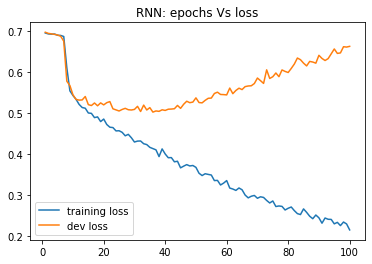

In [72]:
plt.plot(epochs, train_rnn_loss, label='training loss')
plt.plot(epochs, dev_rnn_loss, label='dev loss')
plt.title("RNN: epochs Vs loss")
plt.legend()
plt.show()

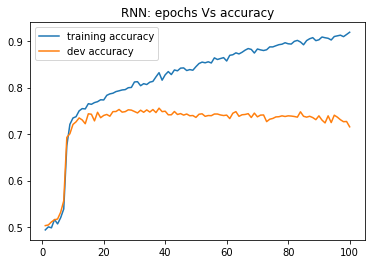

In [77]:
plt.plot(epochs, train_rnn_acc, label='training accuracy')
plt.plot(epochs, dev_rnn_acc, label='dev accuracy')
plt.title("RNN: epochs Vs accuracy")
plt.legend()
plt.show()

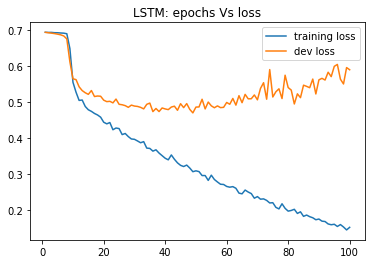

In [75]:
plt.plot(epochs, train_lstm_loss, label='training loss')
plt.plot(epochs, dev_lstm_loss, label='dev loss')
plt.title("LSTM: epochs Vs loss")
plt.legend()
plt.show()

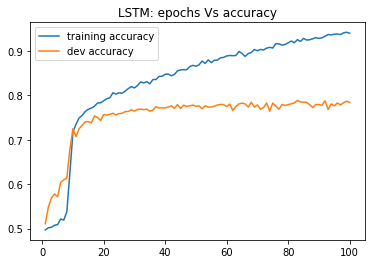

In [78]:
plt.plot(epochs, train_lstm_acc, label='training accuracy')
plt.plot(epochs, dev_lstm_acc, label='dev accuracy')
plt.title("LSTM: epochs Vs accuracy")
plt.legend()
plt.show()

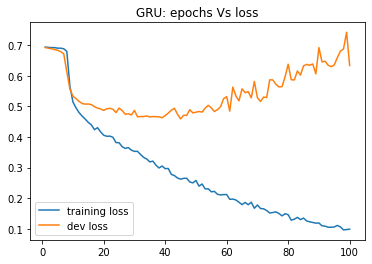

In [76]:
plt.plot(epochs, train_gru_loss, label='training loss')
plt.plot(epochs, dev_gru_loss, label='dev loss')
plt.title("GRU: epochs Vs loss")
plt.legend()
plt.show()

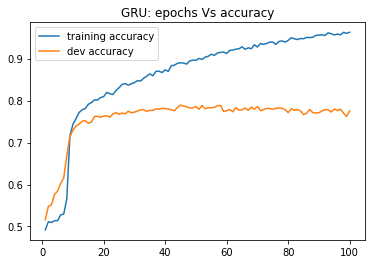

In [79]:
plt.plot(epochs, train_gru_acc, label='training accuracy')
plt.plot(epochs, dev_gru_acc, label='dev accuracy')
plt.title("GRU: epochs Vs accuracy")
plt.legend()
plt.show()

##Evaluation

In [38]:
def predict_sentiment(model,sentence):
    tokenized = [tok for tok in sentence.split()]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    
    tensor = tensor.unsqueeze(1)
#     print(tensor.shape)
    prediction = model(tensor)
#     print(prediction)
    preds, ind= torch.max(F.softmax(prediction.squeeze(0), dim=-1), 1)
#     print(preds)
    return preds, ind

In [45]:
# calculating classification report
test_data = pd.read_csv("/content/drive/My Drive/D4NLP/Ass 1/torchtext_data/test.csv")

In [46]:
pre = [predict_sentiment(model_rnn,k)[1].item() for k in test_data.reviews]
print(classification_report(test_data.senti, pre))

              precision    recall  f1-score   support

           0       0.70      0.74      0.72      1067
           1       0.72      0.69      0.70      1067

    accuracy                           0.71      2134
   macro avg       0.71      0.71      0.71      2134
weighted avg       0.71      0.71      0.71      2134



In [47]:
pre = [predict_sentiment(model_lstm,k)[1].item() for k in test_data.reviews]
print(classification_report(test_data.senti, pre))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78      1067
           1       0.78      0.77      0.78      1067

    accuracy                           0.78      2134
   macro avg       0.78      0.78      0.78      2134
weighted avg       0.78      0.78      0.78      2134



In [48]:
pre = [predict_sentiment(model_gru,k)[1].item() for k in test_data.reviews]
print(classification_report(test_data.senti, pre))

              precision    recall  f1-score   support

           0       0.79      0.74      0.76      1067
           1       0.76      0.80      0.78      1067

    accuracy                           0.77      2134
   macro avg       0.77      0.77      0.77      2134
weighted avg       0.77      0.77      0.77      2134



# Custom

In [ ]:
!wget -O "/content/drive/My Drive/D4NLP/Ass 1/glove.zip" http://nlp.stanford.edu/data/glove.6B.zip

--2020-10-19 22:05:01--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-10-19 22:05:01--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-10-19 22:05:02--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/content/drive/My Driv

In [ ]:
!unzip "/content/drive/My Drive/D4NLP/Ass 1/glove.zip" -d "/content/drive/My Drive/D4NLP/Ass 1"

Archive:  /content/drive/My Drive/D4NLP/Ass 1/glove.zip
  inflating: /content/drive/My Drive/D4NLP/Ass 1/glove.6B.50d.txt  
  inflating: /content/drive/My Drive/D4NLP/Ass 1/glove.6B.100d.txt  
  inflating: /content/drive/My Drive/D4NLP/Ass 1/glove.6B.200d.txt   (warning) cannot set modif./access times
          No such file or directory
  inflating: /content/drive/My Drive/D4NLP/Ass 1/glove.6B.300d.txt  


In [ ]:
def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    f = open(gloveFile,'r',encoding="utf8")
    model = {}
    for line in f:
        try:
            splitLine = line.split()
            word = splitLine[0]
            embedding = np.array([float(val) for val in splitLine[1:]])
            model[word] = embedding
        except:
            print(word)
    print("Done.",len(model)," words loaded!")
    return model

In [ ]:
glove_embeddings = loadGloveModel("/content/drive/My Drive/D4NLP/Ass 1/glove.6B.300d.txt")

Loading Glove Model
Done. 400000  words loaded!


In [ ]:
def create_embedding(data,sequence_length):
  embedding_matrix = np.zeros((len(data),sequence_length,300))
  for d in range(len(data)):
    embed = []
    tokens = data[d].split()
    embed_length = min(sequence_length,len(tokens))
    for token in range(embed_length):
      try:
        embedding_matrix[d][token] = glove_embeddings[tokens[token]]
      except:
        print("Word not in glove",tokens[token])
  return torch.from_numpy(embedding_matrix).float()

In [ ]:
sequence_length = 35

embedding_x_train = create_embedding(x_train,sequence_length)
embedding_x_dev = create_embedding(x_dev,sequence_length)
embedding_x_test = create_embedding(x_test,sequence_length)

In [ ]:
print(embedding_x_train.shape)
print(embedding_x_dev.shape)
print(embedding_x_test.shape)

torch.Size([6396, 35, 300])
torch.Size([2132, 35, 300])
torch.Size([2134, 35, 300])


In [ ]:
y_train = torch.from_numpy(y_train)
y_dev = torch.from_numpy(y_dev)
y_test = torch.from_numpy(y_test)

In [ ]:
import sklearn

embedding_x_train, y_train = sklearn.utils.shuffle(embedding_x_train, y_train)
embedding_x_dev, y_dev = sklearn.utils.shuffle(embedding_x_dev, y_dev)

In [ ]:
embedding_x_train, y_train, embedding_x_dev, y_dev = embedding_x_train.cuda(), y_train.cuda(), embedding_x_dev.cuda(), y_dev.cuda()

In [ ]:
class RNN(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, dropout):
        super(RNN,self).__init__()
        self.hidden_dim = hidden_dim
        # self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, dropout=dropout, nonlinearity='tanh')
        self.fc = nn.Linear(hidden_dim, output_dim)
        # self.fc = nn.Sequential(nn.Linear(hidden_dim, output_dim),nn.Sigmoid())

        self.dropout = nn.Dropout(dropout)
    
    def __init__hidden(self, batch_size):
        hidden = torch.zeros(1,batch_size, self.hidden_dim).cuda()
        return Variable(hidden)

    def forward(self, x):

        #x = [sent len, batch size]
        
        # embedded = self.dropout(self.embedding(x))
        
        #embedded = [sent len, batch size, emb dim]
        # print("x",x.shape)
        hidden = self.__init__hidden(len(x[0]))
        output, hidden = self.rnn(x,hidden)
        # print("out:",output.shape)
        # print("hidden:",hidden.shape)
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        # assert torch.equal(output[-1,:,:], hidden.squeeze(0))

        hidden = self.dropout(hidden)
        # print("hidden2:",hidden.shape)
        out = self.fc(hidden)
        # print("out2:",out.shape)
        return out

In [ ]:
# INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 300
OUTPUT_DIM = 2
DROPOUT = 0.4

model = RNN(EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, DROPOUT).cuda()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
optimizer = optim.RMSprop(model.parameters(), lr=0.00003,weight_decay=0.001)

In [ ]:
class_weights = torch.tensor([1.0, 1.0]).cuda()

In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights).cuda()

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    preds, ind= torch.max(F.softmax(preds, dim=-1), 1)
    correct = (ind == y).float()
    acc = correct.sum()/float(len(correct))
    return acc

In [ ]:
def evaluate(model, x, y, batch_size, criterion):
    
    epoch_loss = 0
    epoch_acc = 0

    model.eval()
    
    with torch.no_grad():
        bar = pyprind.ProgBar(int(len(x)/batch_size), bar_char='█')
        # for batch in iterator:
        for batch_index in tqdm(range(int(len(x)/batch_size))):
            batch, target = x[batch_index*batch_size : batch_index*batch_size + batch_size], y[batch_index*batch_size : batch_index*batch_size + batch_size]
            
            batch = torch.reshape(batch, (sequence_length,batch_size, 300))

            predictions = model(batch)
            
            loss = criterion(predictions[0], target)
            
            acc = binary_accuracy(predictions[0], target)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            bar.update()
    return epoch_loss / (int(len(x)/batch_size)), epoch_acc / (int(len(x)/batch_size))

In [ ]:
def train(model, x, y, batch_size, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    bar = pyprind.ProgBar(int(len(x)/batch_size), bar_char='█')
    for batch_index in range(int(len(x)/batch_size)):
        optimizer.zero_grad()
        # print(np.asarray([x[batch_index : batch_index + batch_size]]).shape)
        batch, target = x[batch_index*batch_size : batch_index*batch_size + batch_size], y[batch_index*batch_size : batch_index*batch_size + batch_size]
            
        batch = torch.reshape(batch, (sequence_length,batch_size, 300))

        batch, target = Variable(batch), Variable(target)

        predictions = model(batch)
        # print(len(target))
        # print("naya")
        # print(predictions[0].shape)
        # print(target.shape)
#         print(predictions.shape, batch.Label.shape, model(batch.Text).shape)
        # print(predictions)
        # print(target)
        loss = criterion(predictions[0], target)
        
        # print(loss.shape)
        acc = binary_accuracy(predictions[0], target)
        # print(acc)
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        bar.update()
    return epoch_loss / (int(len(x)/batch_size)), epoch_acc / (int(len(x)/batch_size))

In [ ]:
N_EPOCHS = 200
BATCH_SIZE = 64

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, embedding_x_train, y_train, BATCH_SIZE, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, embedding_x_dev, y_dev, BATCH_SIZE, criterion)
    
    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |')

In [ ]:
test_loss, test_acc = evaluate(model, embedding_x_test.cuda(), y_test.cuda(), BATCH_SIZE, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% |')

In [ ]:
x_test[:2]

array(["it 's clear that mehta simply wanted to update her beloved genre for the thousands of indians who fancy themselves too sophisticated for the cheese - laced spectacles that pack  'em in on the subcontinent .",
       'compassionately explores the seemingly irreconcilable situation between conservative christian parents and their estranged gay and lesbian children .'],
      dtype='<U266')

In [ ]:
test_ut = ["the movie was horrible .",
           "awesome movie . greatest ever built ."]

In [ ]:
embed_ut = create_embedding(test_ut,sequence_length)

In [ ]:
out = model(embed_ut)